### Classificação de imagens com Keras e Tensorflow

O objetivo deste desafio é classificar imagens usando Deep Learning (Keras e Tensorflow). Iremos utilizar dados de imagens para ensinar a rede as novas classes que precisará reconhecer. Vamos usar um arquivo de fotos de flores licenciadas da creative-commons do Google. O conjunto de dados usado neste exemplo é distribuído como diretórios de imagens, com uma classe de imagem por diretório.

In [70]:
import tensorflow as tf
import tensorflow_hub as hub
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import warnings

warnings.filterwarnings('ignore')

In [60]:

# URL para download do pacote contendo as fotos de flores
URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

# Baixando o arquivo da URL e armazenar com o nome flower_protos no diretório padrão ~/.keras
diretorio_de_dados = tf.keras.utils.get_file(origin=URL, fname="flower_photos", untar=True)


In [61]:
# Navegando na árvore de diretórios utilizando a semântica do SO (Windows)
diretorio_de_dados = pathlib.Path(diretorio_de_dados)

# Listando (QUANTIDADE) os arquivos com extension JPG dentro da árvore de diretórios
quantidade_de_imagens = len(list(diretorio_de_dados.glob("*/*.jpg")))
print(f"Arquivo contém {quantidade_de_imagens} imagens") 

Arquivo contém 3670 imagens


In [64]:
# Classe das flores
classes = [item.name for item in diretorio_de_dados.glob("*") if item.name != "LICENSE.txt"]
classes

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

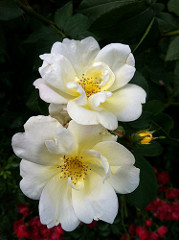

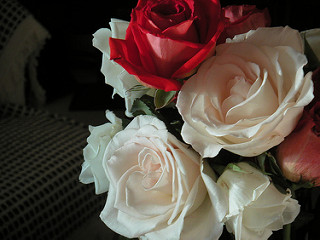

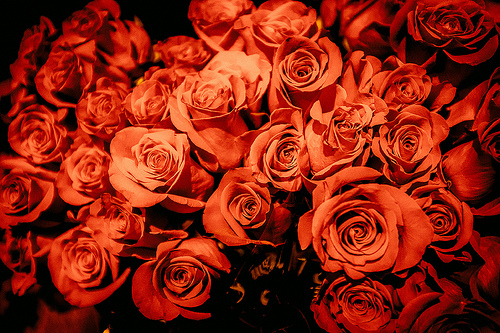

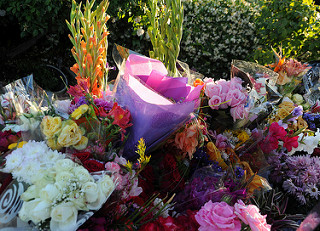

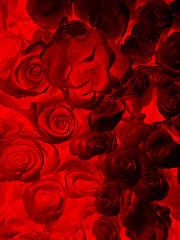

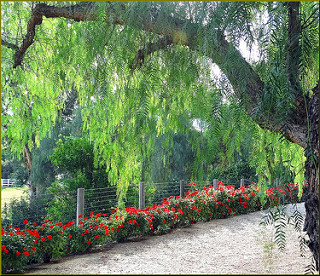

In [69]:
# Obter as imagens da classe ROSES
classe_roses = list( diretorio_de_dados.glob("roses/*") )

# Apresentar 5 imagens da classe ROSES
for imagem in roses[:6]:
    display.display(Image.open(str(imagem)))


In [72]:
tamanho_da_imagem = (224, 224)
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=tamanho_da_imagem, batch_size=32, interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(diretorio_de_dados,
                                                      subset="validation",
                                                      shuffle=False,
                                                      **dataflow_kwargs)

do_data_augmentation = True
if do_data_augmentation:
  # Transformando as imagens do dataset de treinamento
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=40,
                                                                    horizontal_flip=True,
                                                                    width_shift_range=0.2,
                                                                    height_shift_range=0.2,
                                                                    shear_range=0.2,
                                                                    zoom_range=0.2,
                                                                    **datagen_kwargs)
else:
  train_datagen = valid_datagen

train_generator = train_datagen.flow_from_directory(diretorio_de_dados,
                                                      subset="training",
                                                      shuffle=True,
                                                      **dataflow_kwargs)

Found 731 images belonging to 5 classes.
Found 2939 images belonging to 5 classes.


In [75]:
# Criando as camadas da rede neural para o modelo de classificação de imagens (fotos)
model_handle = "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5"
model = tf.keras.Sequential([tf.keras.layers.InputLayer(input_shape=tamanho_da_imagem + (3,)), # camada de entrada
                                hub.KerasLayer(model_handle,
                                                trainable=False),
                                tf.keras.layers.Dropout(rate=0.2),
                                tf.keras.layers.Dense(train_generator.num_classes,
                                kernel_regularizer=tf.keras.regularizers.l2(0.0001))]);

model.build((None,)+tamanho_da_imagem+(3,))
model.summary();

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 1024)              1529968   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 5125      
Total params: 1,535,093
Trainable params: 5,125
Non-trainable params: 1,529,968
_________________________________________________________________


In [76]:
# Compilando o modelo de classificação de imagens (fotos)
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
                metrics=['accuracy'])

steps_per_epoch = train_generator.samples
validation_steps = valid_generator.samples

# Treinando o modelo de classificação CNN com 5 passadas (sem uma GPU vai demorar um pouco, coloque rodar e vai tomar um café, fazer um lanche)
hist = model.fit(train_generator,
                    epochs=5, 
                    steps_per_epoch=steps_per_epoch,
                    validation_data=valid_generator,
                    validation_steps=validation_steps).history

Epoch 1/5
2939/2939 [==============================] - 4773s 2s/step - loss: 0.6415 - acc: 0.9011 - val_loss: 0.6812 - val_acc: 0.8746
Epoch 2/5
2939/2939 [==============================] - 33755s 11s/step - loss: 0.5985 - acc: 0.9258 - val_loss: 0.6794 - val_acc: 0.8772
Epoch 3/5
2939/2939 [==============================] - 4005s 1s/step - loss: 0.5957 - acc: 0.9276 - val_loss: 0.6833 - val_acc: 0.8760
Epoch 4/5
2939/2939 [==============================] - 3751s 1s/step - loss: 0.5952 - acc: 0.9273 - val_loss: 0.6942 - val_acc: 0.8757
Epoch 5/5
2939/2939 [==============================] - 4107s 1s/step - loss: 0.5936 - acc: 0.9290 - val_loss: 0.6814 - val_acc: 0.8772


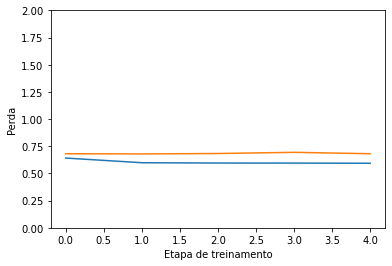

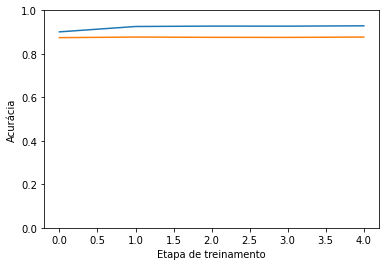

In [77]:
plt.figure()
plt.ylabel("Perda")
plt.xlabel("Etapa de treinamento")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Acurácia")
plt.xlabel("Etapa de treinamento")
plt.ylim([0,1])
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])

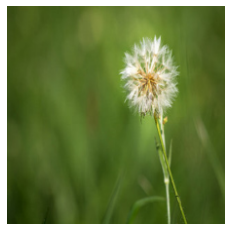

Classe real: dandelion
Previsão da classe: dandelion


In [87]:
def ObterClassificaoImagem(index):
   for nome_da_classe, indice_da_classe in valid_generator.class_indices.items():
      if indice_da_classe == index:
         return nome_da_classe

x, y = next(valid_generator)
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

predict = model.predict(np.expand_dims(image, axis=0))
predict_indice = np.argmax(predict)
print("Classe real: {}".format( ObterClassificaoImagem(true_index) ))
print("Previsão da classe: {}".format( ObterClassificaoImagem(predict_indice) ))